In [20]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


In [21]:
class Geng(nn.Module):
    def __init__(self):

        super(Geng, self).__init__()
        # layer 1
        self.conv1 = nn.Conv2d(in_channels = 8, out_channels = 64 , kernel_size = 3 , stride = 1)
        # In paper, they feed 1x10 downsample emg (kernel=3, filter = 64)

        # layer 2
        self.conv2 = nn.Conv2d(in_channels = 64 , out_channels = 64 , kernel_size = 1 ,stride = 1)        

        
        # layer 3      
        self.linear1 = nn.Linear( 246016 , 512 )
        # layer 4
        self.linear2 = nn.Linear( 512 , 512 )
        # layer 5
        self.linear3 = nn.Linear( 512 , 128 )

      
        

        self.linear4 = nn.Linear( 128 , 4)
        


    def forward(self, x):
        # layer 1
        x = F.relu(self.conv1(x))
        
        # layer 2
        x = F.relu(self.conv2(x))

        x = torch.flatten(x, 1)
        # layer 3

        x = self.linear1( x )
        
        # layer 4
        x = self.linear2( x )
        
        # layer 5
        x = self.linear3( x )

        x = self.linear4( x )
        


        return F.softmax(x)

In [22]:
class Atzori(nn.Module):
    def __init__(self):

        super(Atzori, self).__init__()
        # layer 1
        self.conv1 = nn.Conv2d(in_channels = 8, out_channels = 32 , kernel_size = 3)
        # In paper channel size and kernel size is unclear
        
        # layer 2
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32 , kernel_size = 3)        
        self.pool = nn.AvgPool2d(3, 3)
        
        # layer 3      
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64 , kernel_size = 5)        
        self.pool2 = nn.AvgPool2d(3, 3)
        
        # layer 4
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 64 , kernel_size = (5,1) )
        # it is spesific for kernel size (5,1)
        
        # layer 5
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 64 , kernel_size = 1 )  
        
        

        self.linear = nn.Linear( 320 , 4)
        


    def forward(self, x):
        # layer 1
        x = F.relu(self.conv1(x))
        
        # layer 2
        x = self.pool(F.relu(self.conv2(x)))
        
        # layer 3
        x = self.pool2(F.relu(self.conv3(x)))
        
        # layer 4
        x = F.relu(self.conv4(x))
        
        # layer 5
        x = F.relu(self.conv5(x))
        
        x = torch.flatten(x, 1)
        x = self.linear( x )

        return F.softmax(x)

In [23]:
class Zhai(nn.Module):
    def __init__(self):

        super(Zhai, self).__init__()
        # layer 1
        self.conv1 = nn.Conv2d(in_channels = 8, out_channels = 4 , kernel_size = 4)
        # in paper, defined input size 12 channel 5x5 image after spectogram
        
        # layer 2      
        self.linear1 = nn.Linear( 16 , 32 )
        self.dropout1 = nn.Dropout(p = 0.5)
        # layer 3
        self.linear2 = nn.Linear( 32 , 32 )
        self.dropout2 = nn.Dropout(p = 0.5)
        # layer output
        self.linear3 = nn.Linear( 32 , 4 )

        


    def forward(self, x):
        # layer 1
        x = F.relu(self.conv1(x))
    
        x = torch.flatten(x, 1)

        # layer 2
        x = self.dropout1( self.linear1( x ) )
        
        # layer 3
        x = self.dropout2( self.linear2( x ) )
        
        # layer 5
        x = self.linear3( x )




        return F.softmax(x)

In [24]:


class Net(nn.Module):
    def __init__(self,out_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(4, 12, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(12, 6, 2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(6, 4, 2)
        self.fc1 = nn.Linear(120, 100)
        self.fc2 = nn.Linear(100, 84)
        self.fc3 = nn.Linear(84, out_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch


        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax( self.fc3(x) )
        return x




In [25]:
alpha = 1

In [26]:
df = pd.read_pickle( "./ft_df_alpha_" + str(alpha)+ ".pkl" )

In [27]:
df = pd.read_pickle( "./ft_df_ver1_alpha_" + str(alpha)+ ".pkl" )

In [28]:
df = df[:2000]

In [29]:
num_samples = len(df)
num_channels = 4  # Ch1, Ch3, Ch8, Ch9, Ch10, Ch11
height, width = df.iloc[0]['Ch1'].shape

X = torch.zeros((num_samples, num_channels, height, width), dtype=torch.float)

for ind in range(num_samples):
    # X[ind, 0, :, :] = torch.tensor(df.iloc[ind]['Ch1'], dtype=torch.float)
    # X[ind, 1, :, :] = torch.tensor(df.iloc[ind]['Ch3'], dtype=torch.float)
    X[ind, 0, :, :] = torch.tensor(df.iloc[ind]['Ch8'], dtype=torch.float)
    X[ind, 1, :, :] = torch.tensor(df.iloc[ind]['Ch9'], dtype=torch.float)
    X[ind, 2, :, :] = torch.tensor(df.iloc[ind]['Ch10'], dtype=torch.float)
    X[ind, 3, :, :] = torch.tensor(df.iloc[ind]['Ch11'], dtype=torch.float)

In [30]:
min_vals = X.amin(dim=(2, 3), keepdim=True)
max_vals = X.amax(dim=(2, 3), keepdim=True)
X_normalized = (X - min_vals) / (max_vals - min_vals)

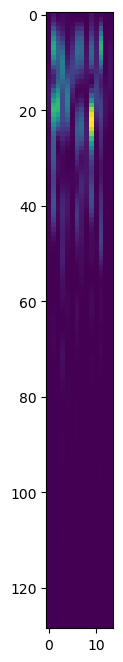

In [11]:
plt.figure( figsize=(3,8))
plt.imshow( X_normalized[500,3,:,:] ) 

In [12]:
"""
Emg (12 columns): sEMG signal. Columns 1-8 are the electrodes equally spaced around the forearm at the height of the radio humeral joint. 
Columns 9 and 10 contain signals from the main activity spot of the muscles flexor and extensor digitorum superficialis, 
while columns 11 and 12 contain signals from the main activity spot of the muscles biceps brachii and triceps brachii.

6 chs should be enough
2 4 9 10 11 12

"""

'\nEmg (12 columns): sEMG signal. Columns 1-8 are the electrodes equally spaced around the forearm at the height of the radio humeral joint. \nColumns 9 and 10 contain signals from the main activity spot of the muscles flexor and extensor digitorum superficialis, \nwhile columns 11 and 12 contain signals from the main activity spot of the muscles biceps brachii and triceps brachii.\n\n6 chs should be enough\n2 4 9 10 11 12\n\n'

In [13]:
one_hot_df = pd.get_dummies(df['y'])

# Convert to PyTorch tensor
y = torch.tensor(one_hot_df.values, dtype=torch.float)


In [14]:
y.shape

torch.Size([2000, 3])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

# Check if GPU is available and get device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Move the data to the GPU
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

Using device: cuda:0


In [16]:
net = Net(y.shape[1])
net.to(device)


Net(
  (conv1): Conv2d(4, 12, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 6, kernel_size=(2, 2), stride=(1, 1))
  (conv3): Conv2d(6, 4, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=120, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [17]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Move the model to the GPU

for epoch in range(400):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Move inputs and labels to the GPU


        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / len(train_loader):.3f}')

print('Finished Training')

Using device: cuda:0


C:\Users\Erkan\AppData\Local\Temp\ipykernel_28216\3911113333.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax( self.fc3(x) )


[1] loss: 1.032
[2] loss: 1.001
[3] loss: 0.994
[4] loss: 0.979
[5] loss: 0.902
[6] loss: 0.884
[7] loss: 0.884
[8] loss: 0.877
[9] loss: 0.875
[10] loss: 0.874
[11] loss: 0.872
[12] loss: 0.868
[13] loss: 0.865
[14] loss: 0.865
[15] loss: 0.863
[16] loss: 0.865
[17] loss: 0.861
[18] loss: 0.867
[19] loss: 0.859
[20] loss: 0.857
[21] loss: 0.855
[22] loss: 0.853
[23] loss: 0.855
[24] loss: 0.854
[25] loss: 0.853
[26] loss: 0.853
[27] loss: 0.849
[28] loss: 0.844
[29] loss: 0.852
[30] loss: 0.844
[31] loss: 0.851
[32] loss: 0.847
[33] loss: 0.845
[34] loss: 0.839
[35] loss: 0.839
[36] loss: 0.834
[37] loss: 0.836
[38] loss: 0.839
[39] loss: 0.840
[40] loss: 0.834
[41] loss: 0.834
[42] loss: 0.830
[43] loss: 0.826
[44] loss: 0.832
[45] loss: 0.845
[46] loss: 0.834
[47] loss: 0.839
[48] loss: 0.828
[49] loss: 0.833
[50] loss: 0.834
[51] loss: 0.823
[52] loss: 0.821
[53] loss: 0.816
[54] loss: 0.823
[55] loss: 0.818
[56] loss: 0.813
[57] loss: 0.811
[58] loss: 0.817
[59] loss: 0.815
[60] l

In [19]:
net.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        _, labels = torch.max(labels, 1)
            
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'[{epoch + 1}] test loss: {test_loss / len(test_loader):.3f}')
print(f'[{epoch + 1}] accuracy on test set: {100 * correct / total:.2f}%')


[400] test loss: 0.896
[400] accuracy on test set: 65.00%


C:\Users\Erkan\AppData\Local\Temp\ipykernel_28216\3911113333.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax( self.fc3(x) )
